In [159]:
#!pip install numpy
#!pip install sklearn
#!pip install scipy
#!pip install seaborn
#!pip install pandas
#!pip install matplotlib
#!pip install xgboost

In [137]:
import numpy as np
import sklearn as skl
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy.fftpack import fft

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 16 octobre (1h30) et le 23 octobre (3h).<br> 
Deadline : 30 otobre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

Antoine, Martinez, MVA

Alexandre, Ver Hulst, MVA

In [25]:
pdws = np.load('./radars/train/pdw-8.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences=pdws['frequence']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']


<div class=consignes> et les fichiers d'annotations:</div>

In [118]:
import json

with open('radars/train_labels.json') as f: 
    dict_labels = json.load(f)

with open('radars/test_labels.json') as f: 
    test_labels = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


<div class=consignes> On compte sur vous, bonne chance ! </div>

# Visualisation des données

<u>a. Visualisation d'un échantillon</u>

Nous commencerons ici par une visualisation des données pour un échantillon de manière à comprendre le type de données qui ressortira

In [162]:
def define_features(data):

    signal_i = data

    mean = np.mean(signal_i)
    variance = np.var(signal_i)
    maxs = np.max(signal_i)
    mins = np.min(signal_i)
    kurtosis = stats.kurtosis(signal_i)
    ptp_amplitude = np.ptp(signal_i)
    spectral_kurtosis = stats.kurtosis(np.abs(fft(signal_i)))
    mean_cross_rate = np.mean(np.diff(np.sign(signal_i - mean) != 0))


    return mean, variance, maxs, mins, kurtosis, ptp_amplitude, spectral_kurtosis, mean_cross_rate

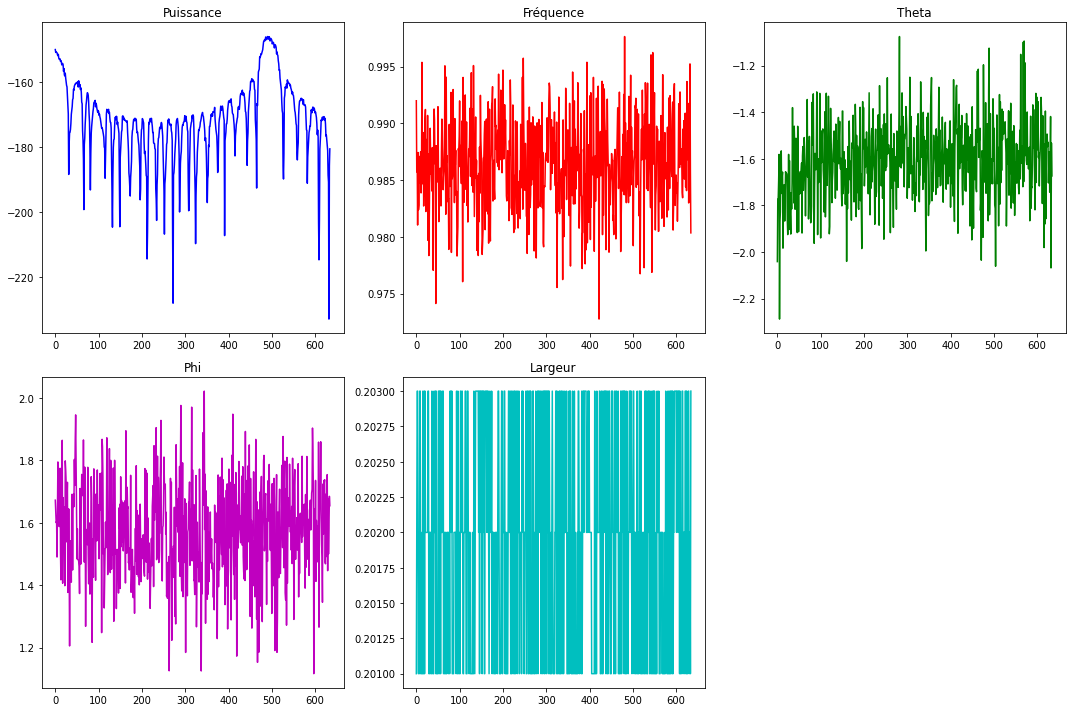

In [161]:
pdws = np.load('radars/train/pdw-2.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences=pdws['frequence']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']

fig, axs = plt.subplots(2, 3, figsize=(15, 10))


sns.lineplot(ax=axs[0, 0], x=range(len(puissances)), y=puissances, color='b')
axs[0, 0].set_title('Puissance')
sns.lineplot(ax=axs[0, 1], x=range(len(frequences)), y=frequences, color='r')
axs[0, 1].set_title('Fréquence')
sns.lineplot(ax=axs[0, 2], x=range(len(theta)), y=theta, color='g')
axs[0, 2].set_title('Theta')
sns.lineplot(ax=axs[1, 0], x=range(len(phi)), y=phi, color='m')
axs[1, 0].set_title('Phi')
sns.lineplot(ax=axs[1, 1], x=range(len(largeurs)), y=largeurs, color='c')
axs[1, 1].set_title('Largeur')
fig.delaxes(axs[1, 2])
plt.tight_layout()
plt.show()


Quelques remarques importantes pour le traitement de la suite :
- <u>**Les variations de puissances**</u> : On observe une multitude de pics de puissances vers le bas. Nous interprétons ces données de la manière suivante : les antennes d'émission passant alternativement des modes *émetteur* à *récepteur*, nous pouvons supposer que celle-ci émet une puissance plus faible à intervalle réguliers. 
D'autre part, nous observons également des formes caractéristiques pour la forme globale (ou enveloppe) de la puissance : si la puissance reçue dépend beaucoup de la distance entre l'émetteur et le récepteur comme vu en cours, nous pouvons également supposer qu'il y a des variations au niveau de la puissance d'émission. Ainsi, il va être intéressant d'étudier ces variations, et plus particulièrement au vu de la forme de la puissance à l'aide de <u>**transformées de Fourier**</u> qui permettraient de quantifier cette forme parabolique caractéristiques, ainsi que les variations de faible période également caractéristiques de ce signal global.
- <u>**Les fréquences et largeurs de bandes**</u> : Nous supposons ici que les fréquences d'émission sont constantes, les variations observées étant simplement dues à un bruitage lors de l'émission et de la réception. En revanche, <u>le rôle joué par la fréquence moyenne est essentiel</u>. En effet, il existe des bandes de fréquence allouées à chaque type d'avion et nous pouvons faire des déductions sur le type d'avion à partir de sa fréquence d'émission. Nous supposons que les largeurs, tout comme les bandes de fréquence, sont particulières du type d'engins motorisés choisis. Nous pouvons ainsi penser que certains avions de détection auront des bandes plus longues que la moyenne, tandis que les avions qui cherchent la furtivité auront des bandes plus courtes
- <u>**Thêta et Phi**</u>: Les données de thêta et phi sont intéressantes pour faire des suppositions sur les variations de vitesse de l'avion. Seulement, cela nécessiterait également la distance, et nous devons faire attention au bruitage des données qui rendent les données difficiles à traiter. La donnée de thêta permet également de savoir si l'engin passe proche ou loin de notre antenne angulairement, ce qui fait que le thêta minimal peut être intéressant à étudier. On notera également que thêta tend vers des valeurs limites de pi et -pi, ce qui est cohérent avec un mobile qui s'écarte à longue distance de notre point.


<u>b. Traitement des données temporelles en les unifiant autour de valeurs importantes</u>

La difficulté majeure de ce projet est de trouver un moyen de traiter les données temporelles. En effet, nous pourrions concaténer toutes les données pour en faire un immense tableau mais cela nécessiterait une capacité de calculs bien trop importante, et un autre problème est qu'il est essentiel de prendre également en compte les données en tant que séquence et pas seulement en tant que colonnes. Nous avons donc décidé d'extraire les informations essentielles de chaque courbe. Les informations extraites sont ainsi les suivantes : la <u>**moyenne**</u>, l'<u>**écart-type**</u>, l'<u>**amplitude crête à crête**</u>, les <u>**Max/Min**</u>, la <u>**transformée de Fourier**</u> et le <u>**Kurtosis**</u> (mesure statistique qui décrit la forme de la distribution d'un ensemble de données, en particulier l'importance des queues de la distribution par rapport à une distribution normale).

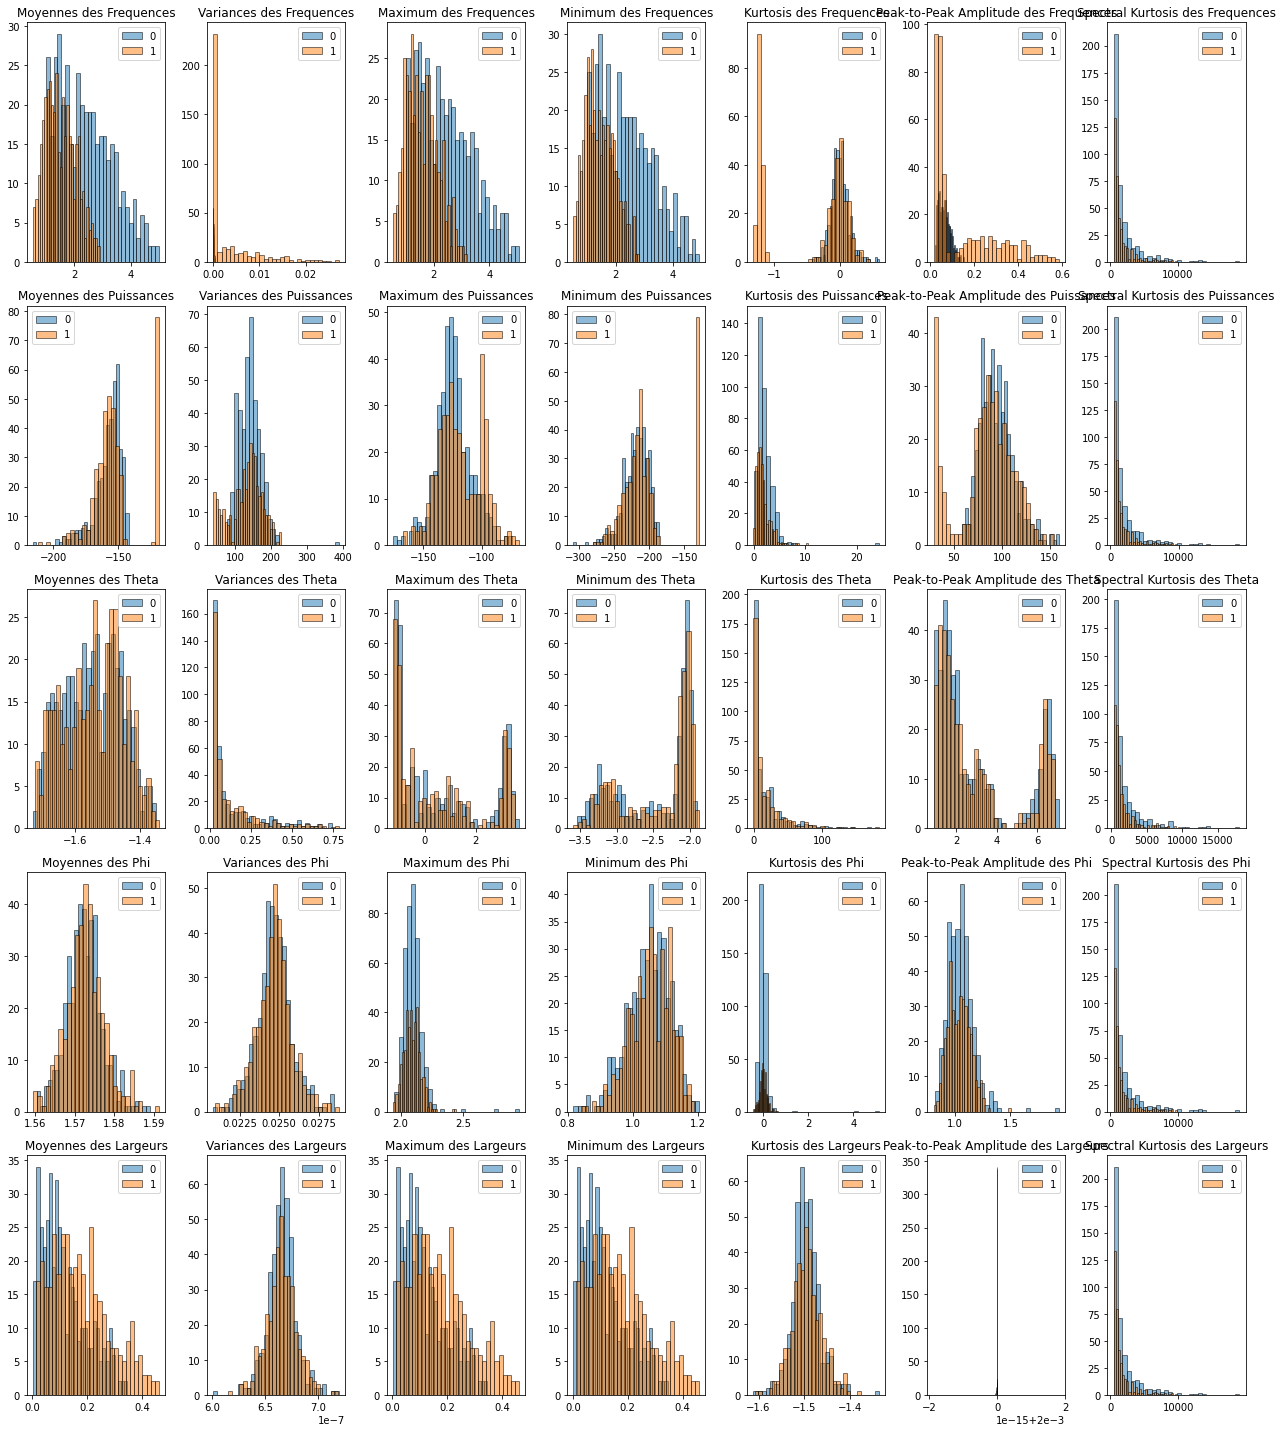

In [164]:
# Création des listes pour stocker les caractéristiques pour chaque classe 
features_0 = []
features_1 = []


for i in range(len(test_labels)):
    pdws = np.load(f'radars/test/pdw-{i}.npz')

    frequences = pdws['frequence']
    puissances = pdws['puissance']
    theta = pdws['theta']
    phi = pdws['phi']
    largeurs = pdws['largeur']
    

    freq_features = define_features(frequences)
    puis_features = define_features(puissances)
    thet_features = define_features(theta)
    phi_features = define_features(phi)
    larg_features = define_features(largeurs)
    
    # Combiner toutes les caractéristiques dans un seul vecteur
    combined_features = np.hstack([freq_features, puis_features, thet_features, phi_features, larg_features])
    

    if test_labels[f'pdw-{i}'] == 'menace':
        features_1.append(combined_features)
    else:
        features_0.append(combined_features)


features_0 = np.array(features_0)
features_1 = np.array(features_1)


names_features = ['Frequences', 'Puissances', 'Theta', 'Phi', 'Largeurs']
stat_names = ["Moyennes", "Variances", "Maximum", "Minimum", "Kurtosis", "Peak-to-Peak Amplitude", "Spectral Kurtosis"]


plt.figure(figsize=(20, 20))


for i in range(len(names_features)):

    for j in range(len(stat_names)):
        plt.subplot(5, 8, i * 8 + j + 1)
        

        features_0_stat = features_0[:, i * 8 + j]
        features_1_stat = features_1[:, i * 8 + j]
        
        # Histogrammes pour les classes 0 (non-menace) et 1 (menace)
        plt.hist(features_0_stat, bins=30, alpha=0.5, label='0', edgecolor='black')
        plt.hist(features_1_stat, bins=30, alpha=0.5, label='1', edgecolor='black')
        

        plt.title(f'{stat_names[j]} des {names_features[i]}')
        plt.legend()
        plt.tight_layout()


plt.show()

De nombreuses données importantes peuvent être extraites des différents graphes tracés ci-dessus :
- **Amplitude Peak-to-Peak des fréquences** : Nous observons tout un pan du graphe au-dessus de 0.10où il n'y a pratiquement que des avions qui sont des menaces, ce qui signifie que si l'avion émet sur une bande de fréquences trop importantes, il est fort probable que celui-ci soit menaçant
- **Moyenne des Fréquences**: Nous observons que les fréquences pour les avions menaçants se situent sur une bande plus faibles et bien plus étroires, là où les avions menaçants émettent sur une large bande.
- **Variance des Phi** : Nous observons que les graphes pour les avions menaçants et non-menaçants sont pratiquement les mêmes, observation faisable pour de nombreuses autres données. Dans ce cas, nous nous attendrons à ce que nos modèles de classification ne prennent que très peu en compte ces données qui ne permettent pas de discerner le type d'avions.

Finalement, les graphes ci-dessus sont essentiels pour comprendre les éléments qui permettent de polariser un avion vers son caractère menaçant ou non.


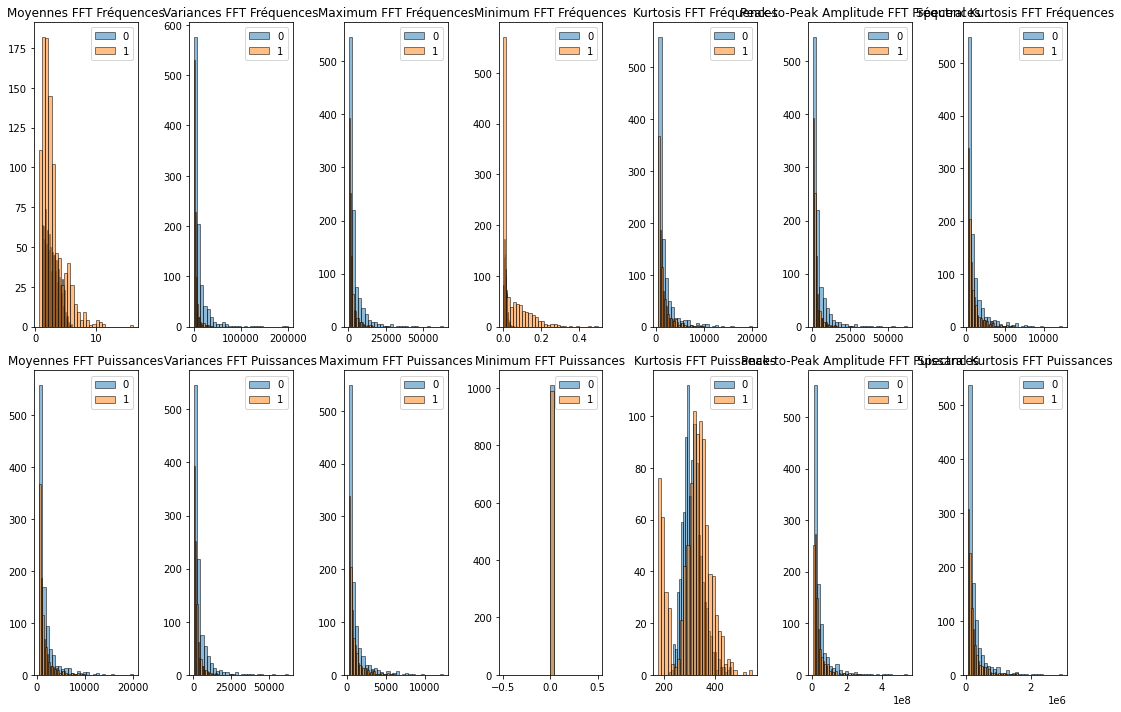

In [167]:

def compute_fft(signal):
    return np.fft.fft(signal)

features_0 = []
features_1 = []

for i in range(len(dict_labels)):
    pdws = np.load(f'radars/train/pdw-{i}.npz')
    
    frequences = pdws['frequence']
    puissances = pdws['puissance']
    
    # Appliquer la FFT aux fréquences et puissances
    fft_frequences = np.abs(compute_fft(frequences))
    fft_puissances = np.abs(compute_fft(puissances))
    

    fft_freq_features = define_features(fft_frequences)
    fft_puis_features = define_features(fft_puissances)
    
    # Combiner toutes les caractéristiques dans un seul vecteur
    combined_features = np.hstack([fft_freq_features, fft_puis_features])
    

    if dict_labels[f'pdw-{i}'] == 'menace':
        features_1.append(combined_features)
    else:
        features_0.append(combined_features)

    

features_0 = np.array(features_0)
features_1 = np.array(features_1)
names_features = ['FFT Fréquences', 'FFT Puissances']
plt.figure(figsize=(15, 10))


for i in range(len(names_features)):

    for j in range(len(stat_names)):
        plt.subplot(2, 7, i * 7 + j + 1)  
        
        
        features_0_stat = features_0[:, i * 4 + j]
        features_1_stat = features_1[:, i * 4 + j]
        
        plt.hist(features_0_stat, bins=30, alpha=0.5, label='0', edgecolor='black')
        plt.hist(features_1_stat, bins=30, alpha=0.5, label='1', edgecolor='black')
        
        
        plt.title(f'{stat_names[j]} {names_features[i]}')
        plt.legend()
        plt.tight_layout()


plt.show()

Nous remarquons ici de nombreux autres éléments. Par exemple, sur le minimum des FFT en fréquences, les avions menaçants ont eds minimums qui ont des fréquences plus hautes initialement, là ou les avions non-menaçants sont très polarisés sur le début du graphe. A nouveau, de nombreuses observations sont importantes sur ces graphes, et nous permettront de choisir les bon critères de classification à la fin.

# Modèle simple de départ

Notre modèle initial consiste à prendre la moyenne de chaque variable à notre disposition, et d'entraîner un modèle de régression linéaire sur ces données.

In [120]:

largeurs_mean = []
frequences_mean = []
puissances_mean = []
theta_mean = []
labels = []

for i in range(len(dict_labels)):
    pdws = np.load(f'./radars/train/pdw-{i}.npz')
    dates = pdws['date']
    largeurs = pdws['largeur']
    frequences=pdws['frequence']
    puissances = pdws['puissance']
    theta = pdws['theta']

    largeurs_mean.append(np.mean(largeurs))
    frequences_mean.append(np.mean(frequences))
    puissances_mean.append(np.mean(puissances))
    theta_mean.append(np.mean(theta))
    labels.append(1 * (dict_labels[f'pdw-{i}'] == 'menace'))

Data_train = pd.DataFrame({'largeurs' : largeurs_mean,'frequences':frequences_mean,'puissances' : puissances_mean,'theta' : theta_mean})
labels_train = pd.DataFrame({'labels' : labels})


In [125]:
largeurs_mean = []
frequences_mean = []
puissances_mean = []
theta_mean = []
labels = []

for i in range(len(test_labels)):
    pdws = np.load(f'./radars/test/pdw-{i}.npz')
    dates = pdws['date']
    largeurs = pdws['largeur']
    frequences=pdws['frequence']
    puissances = pdws['puissance']
    theta = pdws['theta']

    largeurs_mean.append(np.mean(largeurs))
    frequences_mean.append(np.mean(frequences))
    puissances_mean.append(np.mean(puissances))
    theta_mean.append(np.mean(theta))
    labels.append(1 * (test_labels[f'pdw-{i}'] == 'menace'))

Data_test = pd.DataFrame({'largeurs' : largeurs_mean,'frequences':frequences_mean,'puissances' : puissances_mean,'theta' : theta_mean})
labels_test = pd.DataFrame({'labels' : labels})

In [126]:
model = LinearRegression()  # Utilisation d'un modèle classique de régression linéaire

model.fit(Data_train,labels_train)
y_pred = model.predict(Data_test)
y_pred = (y_pred>0.5)*1  # Notre modèle va prédire un floatant entre 0 et 1 et nous voulons séparer cela en deux parties
print(accuracy_score(y_pred,labels_test))

0.72375


On obtient une accuracy de **0.72**, ce qui peut nous donner un bon point de départ pour comparer avec les futurs algorithmes.

# Un modèle plus complexe

## Ajout de variables

Pour la suite, nous avons voulu ajouter d'autre valeurs pouvant aider la caractérisation de chacun des relevés. 

Pour chaque variable, nous avons alors ajouté le minimum, le maximum, la variance, l'amplitude, le kurtosis, le kurtosis spectral et enfin le taux de franchissement de la moyenne. De plus, pour la puissance et la fréquence, comme expliqué dans la visualisaton des données en partie 1, il nous semblait cohérent de considérer la transformée de Fourier de celle-ci.

Cela augmente considérablement notre nombre de variable. Nous allons alors, pour palier à cela, utiliser des types de modèle qui permettent d'assigner un poids à chacune des variables, dans le but d'enlever les variables inutiles dans le modèle final.

In [129]:
def define_features(data):

    signal_i = data

    mean = np.mean(signal_i)
    variance = np.var(signal_i)
    maxs = np.max(signal_i)
    mins = np.min(signal_i)
    kurtosis = stats.kurtosis(signal_i)
    ptp_amplitude = np.ptp(signal_i)
    spectral_kurtosis = stats.kurtosis(np.abs(fft(signal_i)))
    mean_cross_rate = np.mean(np.diff(np.sign(signal_i - mean) != 0))


    return mean, variance, maxs, mins, kurtosis, ptp_amplitude, spectral_kurtosis, mean_cross_rate

Création des données d'netraînement et de test:

In [130]:
train_df = pd.DataFrame()

for i in range(len(dict_labels)):
    pdws = np.load(f'radars/train/pdw-{i}.npz')
    dates = pdws['date']
    largeurs = pdws['largeur']
    frequences=pdws['frequence']
    puissances = pdws['puissance']
    theta = pdws['theta']
    phi = pdws['phi']
    freq_means, freq_vars, freq_maxs, freq_mins, freq_kurtosis, freq_ptp_amplitude, freq_spectral_kurtosis, freq_mean_cross_rate = define_features(frequences)
    puis_means, puis_vars, puis_maxs, puis_mins, puis_kurtosis, puis_ptp_amplitude, puis_spectral_kurtosis, puis_mean_cross_rate = define_features(puissances)
    thet_means, thet_vars, thet_maxs, thet_mins, thet_kurtosis, thet_ptp_amplitude, thet_spectral_kurtosis, thet_mean_cross_rate = define_features(theta)
    phi_means, phi_vars, phi_maxs, phi_mins, phi_kurtosis, phi_ptp_amplitude, phi_spectral_kurtosis, phi_mean_cross_rate = define_features(phi)
    larg_means, larg_vars, larg_maxs, larg_mins, larg_kurtosis, larg_ptp_amplitude, larg_spectral_kurtosis, larg_mean_cross_rate = define_features(largeurs)
    # fft de la puissance
    fft_puis = np.abs(fft(puissances))
    fft_means, fft_vars, fft_maxs, fft_mins, fft_kurtosis, fft_ptp_amplitude, fft_spectral_kurtosis, fft_mean_cross_rate = define_features(fft_puis)
    #fft fréquence
    fft_freq_means, fft_freq_vars, fft_freq_maxs, fft_freq_mins, fft_freq_kurtosis, fft_freq_ptp_amplitude, fft_freq_spectral_kurtosis, fft_freq_mean_cross_rate = define_features(np.abs(fft(frequences)))
    label = 1 if dict_labels[f'pdw-{i}'] == 'menace' else 0
    
    train_df = pd.concat([train_df, pd.DataFrame({ 
    'freq_means': [freq_means], 'freq_vars': [freq_vars], 'freq_maxs': [freq_maxs], 'freq_mins': [freq_mins], 'freq_kurtosis': [freq_kurtosis], 
    'freq_ptp_amplitude': [freq_ptp_amplitude], 'freq_spectral_kurtosis': [freq_spectral_kurtosis], 'freq_mean_cross_rate': [freq_mean_cross_rate], 
    'puis_means': [puis_means], 'puis_vars': [puis_vars], 'puis_maxs': [puis_maxs], 'puis_mins': [puis_mins], 'puis_kurtosis': [puis_kurtosis], 
    'puis_ptp_amplitude': [puis_ptp_amplitude], 'puis_spectral_kurtosis': [puis_spectral_kurtosis], 'puis_mean_cross_rate': [puis_mean_cross_rate], 
    'theta_means': [thet_means], 'theta_vars': [thet_vars], 'theta_maxs': [thet_maxs], 'theta_mins': [thet_mins], 'theta_kurtosis': [thet_kurtosis], 
    'theta_ptp_amplitude': [thet_ptp_amplitude], 'theta_spectral_kurtosis': [thet_spectral_kurtosis], 'theta_mean_cross_rate': [thet_mean_cross_rate], 
    'phi_means': [phi_means], 'phi_vars': [phi_vars], 'phi_maxs': [phi_maxs], 'phi_mins': [phi_mins], 'phi_kurtosis': [phi_kurtosis], 
    'phi_ptp_amplitude': [phi_ptp_amplitude], 'phi_spectral_kurtosis': [phi_spectral_kurtosis], 'phi_mean_cross_rate': [phi_mean_cross_rate], 
    'largeur_means': [larg_means], 'largeur_vars': [larg_vars], 'largeur_maxs': [larg_maxs], 'largeur_mins': [larg_mins], 'largeur_kurtosis': [larg_kurtosis], 
    'largeur_ptp_amplitude': [larg_ptp_amplitude], 'largeur_spectral_kurtosis': [larg_spectral_kurtosis], 'largeur_mean_cross_rate': [larg_mean_cross_rate], 
    'fft_means': [fft_means], 'fft_vars': [fft_vars], 'fft_maxs': [fft_maxs], 'fft_mins': [fft_mins], 'fft_kurtosis': [fft_kurtosis], 
    'fft_ptp_amplitude': [fft_ptp_amplitude], 'fft_spectral_kurtosis': [fft_spectral_kurtosis], 'fft_mean_cross_rate': [fft_mean_cross_rate], 
    'fft_freq_means': [fft_freq_means], 'fft_freq_vars': [fft_freq_vars], 'fft_freq_maxs': [fft_freq_maxs], 'fft_freq_mins': [fft_freq_mins], 
    'fft_freq_kurtosis': [fft_freq_kurtosis], 'fft_freq_ptp_amplitude': [fft_freq_ptp_amplitude], 'fft_freq_spectral_kurtosis': [fft_freq_spectral_kurtosis], 
    'fft_freq_mean_cross_rate': [fft_freq_mean_cross_rate], 'label': [label]
})], axis=0, ignore_index=True)



test_df = pd.DataFrame()
for i in range(len(test_labels)):
    pdws = np.load(f'radars/test/pdw-{i}.npz')
    dates = pdws['date']
    largeurs = pdws['largeur']
    frequences=pdws['frequence']
    puissances = pdws['puissance']
    theta = pdws['theta']
    phi = pdws['phi']
    freq_means, freq_vars, freq_maxs, freq_mins, freq_kurtosis, freq_ptp_amplitude, freq_spectral_kurtosis, freq_mean_cross_rate = define_features(frequences)
    puis_means, puis_vars, puis_maxs, puis_mins, puis_kurtosis, puis_ptp_amplitude, puis_spectral_kurtosis, puis_mean_cross_rate = define_features(puissances)
    thet_means, thet_vars, thet_maxs, thet_mins, thet_kurtosis, thet_ptp_amplitude, thet_spectral_kurtosis, thet_mean_cross_rate = define_features(theta)
    phi_means, phi_vars, phi_maxs, phi_mins, phi_kurtosis, phi_ptp_amplitude, phi_spectral_kurtosis, phi_mean_cross_rate = define_features(phi)
    larg_means, larg_vars, larg_maxs, larg_mins, larg_kurtosis, larg_ptp_amplitude, larg_spectral_kurtosis, larg_mean_cross_rate = define_features(largeurs)
    # fft de la puissance
    fft_puis = np.abs(fft(puissances))
    fft_means, fft_vars, fft_maxs, fft_mins, fft_kurtosis, fft_ptp_amplitude, fft_spectral_kurtosis, fft_mean_cross_rate = define_features(fft_puis)

    #fft fréquence
    fft_freq_means, fft_freq_vars, fft_freq_maxs, fft_freq_mins, fft_freq_kurtosis, fft_freq_ptp_amplitude, fft_freq_spectral_kurtosis, fft_freq_mean_cross_rate = define_features(np.abs(fft(frequences)))
    label = 1 if test_labels[f'pdw-{i}'] == 'menace' else 0
    test_df = pd.concat([test_df, pd.DataFrame({ 
    'freq_means': [freq_means], 'freq_vars': [freq_vars], 'freq_maxs': [freq_maxs], 'freq_mins': [freq_mins], 'freq_kurtosis': [freq_kurtosis], 
    'freq_ptp_amplitude': [freq_ptp_amplitude], 'freq_spectral_kurtosis': [freq_spectral_kurtosis], 'freq_mean_cross_rate': [freq_mean_cross_rate], 
    'puis_means': [puis_means], 'puis_vars': [puis_vars], 'puis_maxs': [puis_maxs], 'puis_mins': [puis_mins], 'puis_kurtosis': [puis_kurtosis], 
    'puis_ptp_amplitude': [puis_ptp_amplitude], 'puis_spectral_kurtosis': [puis_spectral_kurtosis], 'puis_mean_cross_rate': [puis_mean_cross_rate], 
    'theta_means': [thet_means], 'theta_vars': [thet_vars], 'theta_maxs': [thet_maxs], 'theta_mins': [thet_mins], 'theta_kurtosis': [thet_kurtosis], 
    'theta_ptp_amplitude': [thet_ptp_amplitude], 'theta_spectral_kurtosis': [thet_spectral_kurtosis], 'theta_mean_cross_rate': [thet_mean_cross_rate], 
    'phi_means': [phi_means], 'phi_vars': [phi_vars], 'phi_maxs': [phi_maxs], 'phi_mins': [phi_mins], 'phi_kurtosis': [phi_kurtosis], 
    'phi_ptp_amplitude': [phi_ptp_amplitude], 'phi_spectral_kurtosis': [phi_spectral_kurtosis], 'phi_mean_cross_rate': [phi_mean_cross_rate], 
    'largeur_means': [larg_means], 'largeur_vars': [larg_vars], 'largeur_maxs': [larg_maxs], 'largeur_mins': [larg_mins], 'largeur_kurtosis': [larg_kurtosis], 
    'largeur_ptp_amplitude': [larg_ptp_amplitude], 'largeur_spectral_kurtosis': [larg_spectral_kurtosis], 'largeur_mean_cross_rate': [larg_mean_cross_rate], 
    'fft_means': [fft_means], 'fft_vars': [fft_vars], 'fft_maxs': [fft_maxs], 'fft_mins': [fft_mins], 'fft_kurtosis': [fft_kurtosis], 
    'fft_ptp_amplitude': [fft_ptp_amplitude], 'fft_spectral_kurtosis': [fft_spectral_kurtosis], 'fft_mean_cross_rate': [fft_mean_cross_rate], 
    'fft_freq_means': [fft_freq_means], 'fft_freq_vars': [fft_freq_vars], 'fft_freq_maxs': [fft_freq_maxs], 'fft_freq_mins': [fft_freq_mins], 
    'fft_freq_kurtosis': [fft_freq_kurtosis], 'fft_freq_ptp_amplitude': [fft_freq_ptp_amplitude], 'fft_freq_spectral_kurtosis': [fft_freq_spectral_kurtosis], 
    'fft_freq_mean_cross_rate': [fft_freq_mean_cross_rate], 'label': [label]
})], axis=0, ignore_index=True)                          

In [157]:
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']

X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

# Modèle XG Boost
model_XG = XGBClassifier()
model_XG.fit(X_train, y_train)
y_pred = model_XG.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy XG Boost: {accuracy}")


# Modèle Random Forest


model_RF = RandomForestClassifier()
model_RF.fit(X_train, y_train)
y_pred = model_RF.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Random Forest: {accuracy}")

# Modèle AdaBoost


model_ADA = AdaBoostClassifier()
model_ADA.fit(X_train, y_train)
y_pred = model_ADA.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Adaboost: {accuracy}")

Accuracy XG Boost: 0.87875
Accuracy Random Forest: 0.88
Accuracy Adaboost: 0.88125


On obtient des précisions autour de **0.88** pour nos 3 modèles, ce qui est largement supérieur à notre modèle initial qui avait une précision de **0.72**.
Nous pouvons noter deux points:
- D'une part les modèles utilisés dans cette deuxième partie sont certes plus complexes qu'une régression linéaire mais aussi en général bien plus performant. 
- D'autre part l'ajout de données pour caractériser nos signaux a été très bénéfique. En effet, les différents indicateurs que nous avons pris en compte ont permis de donner plus d'information au modèle.

## Importance des variables

Reste maintenant à déterminer quelles variables sont utiles et lesquelles ne le sont pas. Nous allons voir que cela peut différer selon les modèles. 

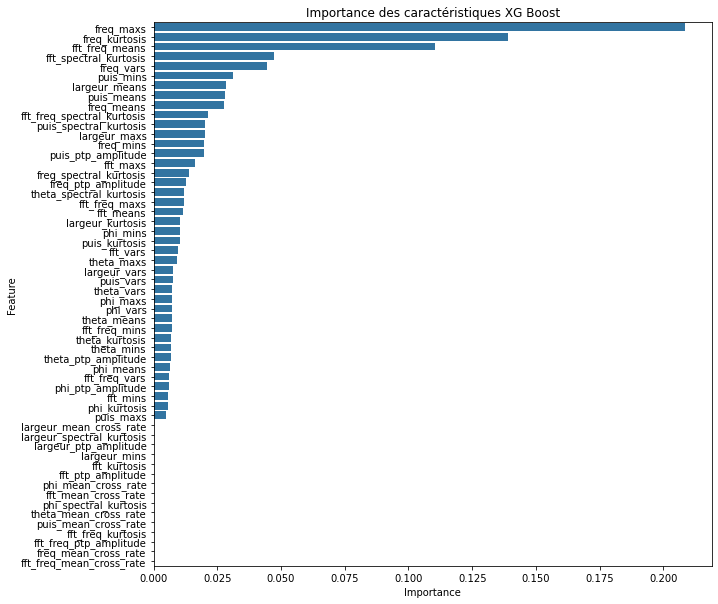

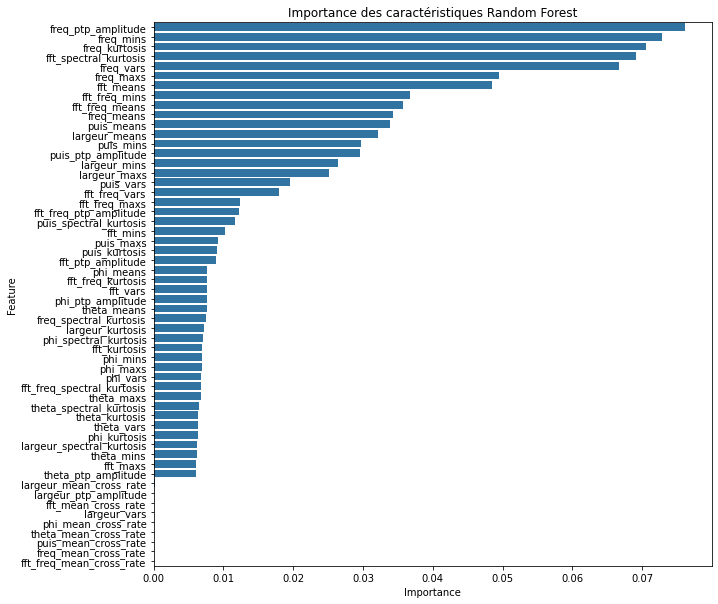

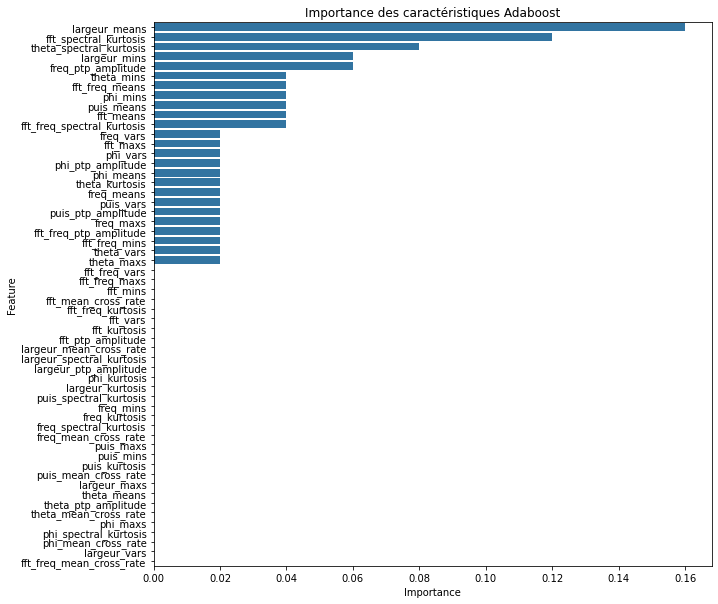

In [141]:
feature_importances = model_XG.feature_importances_  

features = X_train.columns  
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Trier les caractéristiques par ordre décroissant d'importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize = (10,10))
sns.barplot(data = importance_df, x = 'Importance',y = 'Feature')
plt.title('Importance des caractéristiques XG Boost')
plt.show()

feature_importances = model_RF.feature_importances_

features = X_train.columns  
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})


importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize = (10,10))
sns.barplot(data = importance_df, x = 'Importance',y = 'Feature')
plt.title('Importance des caractéristiques Random Forest')
plt.show()

feature_importances = model_ADA.feature_importances_

features = X_train.columns  
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})


importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize = (10,10))
sns.barplot(data = importance_df, x = 'Importance',y = 'Feature')
plt.title('Importance des caractéristiques Adaboost')
plt.show()



Nous constatons que dans les 3 modèles, de nombreuses variables ne sont pas utilisées (ont un poids égal à 0). En particulier pour le modèle Ada_boost, on compte uniquement 25 variables utilisées sur les 56 initialement présentes dans le dataset. Nous pouvons alors essayer d'enlever ces variables pour le modèle Adaboost, et vérifier que cela n'impacte pas notre modèle.

## Diminuer le nombre de variables pour Adaboost

In [154]:
X_train = train_df.drop(columns=['label'])
X_train = X_train.drop(columns = importance_df[importance_df['Importance']==0]['Feature']) # Nous retirons les variables de poids nul dans le modèle précédent
y_train = train_df['label']

X_test = test_df.drop(columns=['label'])
X_test = X_test.drop(columns = importance_df[importance_df['Importance']==0]['Feature']) # De même pour les données de test
y_test = test_df['label']

In [155]:
model_ADA = AdaBoostClassifier()
model_ADA.fit(X_train, y_train)
y_pred = model_ADA.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.88125


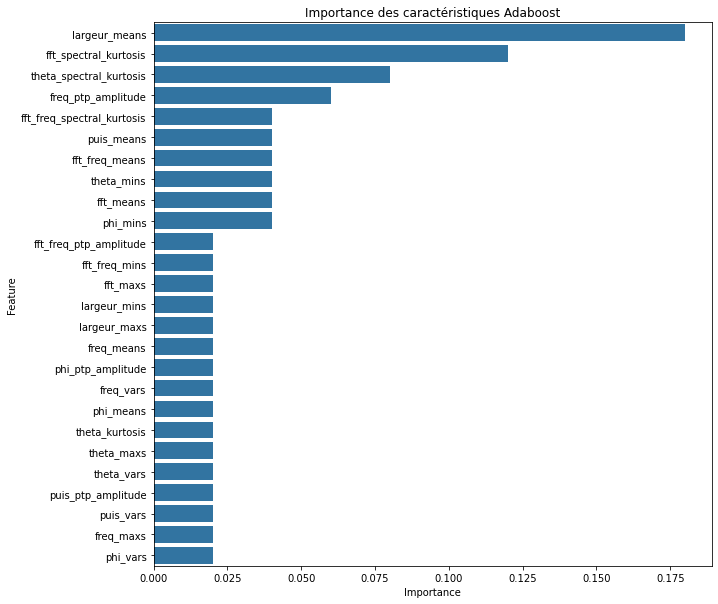

In [156]:
feature_importances = model_ADA.feature_importances_

features = X_train.columns  
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Trier les caractéristiques par ordre décroissant d'importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize = (10,10))
sns.barplot(data = importance_df, x = 'Importance',y = 'Feature')
plt.title('Importance des caractéristiques Adaboost')
plt.show()

Nous pouvons remarquer ici que la précision est la même que précedemment sans enlever les variables qui avaient un poids de 0 pour le modèle Adaboost. Ceci n'est pas étonnant car vu que leur poids était de 0, ils n'intervenaient pas dans le modèle. Néanmoins, les enlever permet d'une part d'avoir moins de données en entrée, moins de puissance de calculs nécessaire, et d'autre part cela permet de clarifier le modèle. En effet il est plus aisé de comprendre l'importance et le rôle de chaque variable lorsque celles-ci sont moins nombreuses.

Notre modèle final est donc un modèle **Adaboost** qui possède une accuracy de **0.8125** en prenant 25 variables en entrée.